<a href="https://colab.research.google.com/github/dawmro/pytorch_tutorial/blob/main/Tabular_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Initializations and Dataset

In [4]:
# Import necessary libraries for interacting with the notebook and displaying content.
from IPython import get_ipython
from IPython.display import display

In [5]:
# Install the opendatasets library for downloading datasets.
!pip install opendatasets

In [6]:
# Import the opendatasets library and download the "Rice Type Classification" dataset from Kaggle.
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


# 2. Imports

In [7]:
# Import necessary libraries for building and training the model.
import torch # PyTorch main framework
import torch.nn as nn # Used for defining neural network layers
from torch.optim import Adam # Adam optimizer for training
from torch.utils.data import Dataset, DataLoader # Dataset and DataLoader for data handling
from torchsummary import summary # Visualize model architecture and parameters
from sklearn.model_selection import train_test_split # Split data into train, validation, and test sets
from sklearn.metrics import accuracy_score # Calculate testing accuracy
import matplotlib.pyplot as plt # Plotting training progress
import pandas as pd # Data reading and preprocessing
import numpy as np # Mathematical operations

In [10]:
# Define device to run on ('cuda' if available, otherwise 'cpu').
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device agnostic code
print(device)

cpu


# 3. Dataset

In [16]:
# Read the data
data_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
# Print/visualize the first 5 rows of the data
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [17]:
# Possible Outputs
print("Output possibilities: ", data_df["Class"].unique())
# Print data shape
print("Data Shape (rows, cols): ", data_df.shape)

Output possibilities:  [1 0]
Data Shape (rows, cols):  (18185, 12)


In [20]:
# Drop missing/null values
data_df.dropna(inplace=True)

# Drop 'id' column only if it exists
if 'id' in data_df.columns:
    data_df.drop(["id"], axis=1, inplace=True)

In [22]:
print("Output possibilities: ", data_df["Class"].unique()) # Possible Outputs
print("Data Shape (rows, cols): ", data_df.shape) # Print data shape
data_df.head() # Print/visualize the first 5 rows of the data

Output possibilities:  [1 0]
Data Shape (rows, cols):  (18185, 11)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


Class Distribution:
 Class
1    9985
0    8200
Name: count, dtype: int64


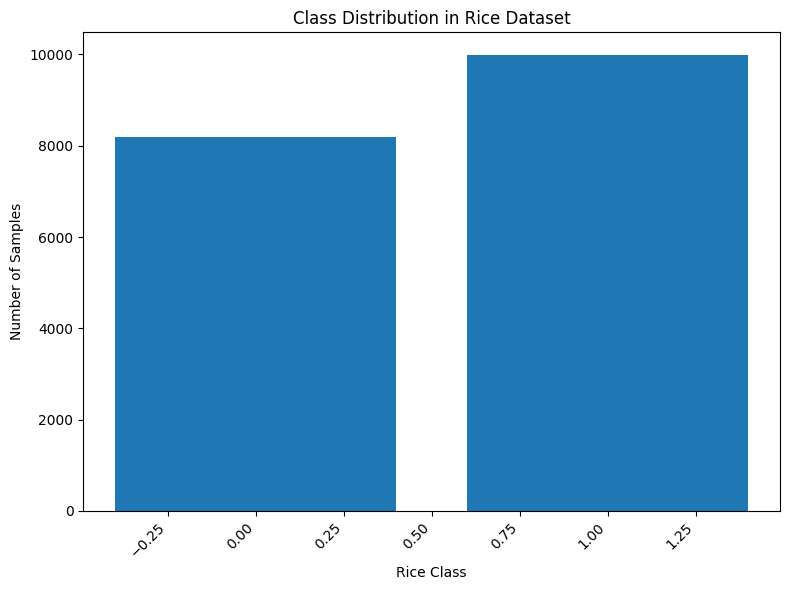

In [23]:
# Check the distribution of classes
class_distribution = data_df['Class'].value_counts()

# Print the distribution
print("Class Distribution:\n", class_distribution)

# Visualize the distribution using a bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.bar(class_distribution.index, class_distribution.values)
plt.title('Class Distribution in Rice Dataset')
plt.xlabel('Rice Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# 4. Data Preprocessing

In [26]:
# Creating a copy of the original Dataframe to use to normalize inference
original_df = data_df.copy()


In [31]:
# Get the maximum values for each column
max_values = original_df.max()

# Get the minimum values for each column
min_values = original_df.min()

# Display the maximum and minimum values
print("Maximum Values:\n", max_values)
print("\nMinimum Values:\n", min_values)

Maximum Values:
 Area               10210.000000
MajorAxisLength      183.211434
MinorAxisLength       82.550762
Eccentricity           0.966774
ConvexArea         11008.000000
EquivDiameter        114.016559
Extent                 0.886573
Perimeter            508.511000
Roundness              0.904748
AspectRation           3.911845
Class                  1.000000
dtype: float64

Minimum Values:
 Area               2522.000000
MajorAxisLength      74.133114
MinorAxisLength      34.409894
Eccentricity          0.676647
ConvexArea         2579.000000
EquivDiameter        56.666658
Extent                0.383239
Perimeter           197.015000
Roundness             0.174590
AspectRation          1.358128
Class                 0.000000
dtype: float64


In [29]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Select the numerical features to normalize (excluding the 'Class' column)
numerical_features = data_df.select_dtypes(include=['number']).columns
numerical_features = numerical_features.drop('Class')  # Exclude 'Class' if it's numerical

# Fit the scaler on the training data and transform it
normalized_data = scaler.fit_transform(data_df[numerical_features])

# Create a new DataFrame with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=numerical_features, index=data_df.index)

# Add the 'Class' column back to the normalized DataFrame
normalized_df['Class'] = data_df['Class']
normalized_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.262097,0.165901,0.614922,0.149139,0.248903,0.337191,0.544960,0.244209,0.807934,0.032371,1
1,0.045525,0.005123,0.352934,0.168567,0.051726,0.066336,0.655171,0.036283,0.899898,0.037204,1
2,0.068418,0.019803,0.366292,0.188069,0.065607,0.098164,0.746848,0.041724,0.950265,0.042222,1
3,0.071670,0.026591,0.363903,0.213671,0.068573,0.102609,0.795277,0.043795,0.952688,0.049077,1
4,0.152315,0.100769,0.456247,0.250355,0.145094,0.207586,0.767156,0.106958,0.958906,0.059471,1


In [30]:
# Get the maximum values for each column
max_values = normalized_df.max()

# Get the minimum values for each column
min_values = normalized_df.min()

# Display the maximum and minimum values
print("Maximum Values:\n", max_values)
print("\nMinimum Values:\n", min_values)

Maximum Values:
 Area               1.0
MajorAxisLength    1.0
MinorAxisLength    1.0
Eccentricity       1.0
ConvexArea         1.0
EquivDiameter      1.0
Extent             1.0
Perimeter          1.0
Roundness          1.0
AspectRation       1.0
Class              1.0
dtype: float64

Minimum Values:
 Area               0.0
MajorAxisLength    0.0
MinorAxisLength    0.0
Eccentricity       0.0
ConvexArea         0.0
EquivDiameter      0.0
Extent             0.0
Perimeter          0.0
Roundness          0.0
AspectRation       0.0
Class              0.0
dtype: float64


In [32]:
data_df = normalized_df.copy()
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.262097,0.165901,0.614922,0.149139,0.248903,0.337191,0.544960,0.244209,0.807934,0.032371,1
1,0.045525,0.005123,0.352934,0.168567,0.051726,0.066336,0.655171,0.036283,0.899898,0.037204,1
2,0.068418,0.019803,0.366292,0.188069,0.065607,0.098164,0.746848,0.041724,0.950265,0.042222,1
3,0.071670,0.026591,0.363903,0.213671,0.068573,0.102609,0.795277,0.043795,0.952688,0.049077,1
4,0.152315,0.100769,0.456247,0.250355,0.145094,0.207586,0.767156,0.106958,0.958906,0.059471,1


# 5. Data Splitting

In [34]:
X = np.array(data_df.iloc[:,:-1]) # Get the inputs, all rows and all columns except last column (output)
Y = np.array(data_df.iloc[:, -1]) # Get the ouputs, all rows and last column only (output column)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3) # Create the training split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5) # Create the validation split

print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%") # Print training shape
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%") # Print validation shape
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%") # Print testing shape


Training set is:  12729  rows which is  70.0 %
Validation set is:  2728  rows which is  15.0 %
Testing set is:  2728  rows which is  15.0 %


# 6. Dataset Object

In [35]:
class dataset(Dataset):
    """
    Custom dataset class for handling the rice classification data.
    """
    def __init__(self, X, Y):
        """
        Initializes the dataset with input features (X) and labels (Y).

        Args:
            X (numpy.ndarray): Input features.
            Y (numpy.ndarray): Target labels.
        """
        # Convert input features and labels to PyTorch tensors and move them to the device (CPU or GPU)
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.X)

    def __getitem__(self, index):
        """
        Returns a single data point (input features and label) at the given index.

        Args:
            index (int): Index of the data point to retrieve.

        Returns:
            tuple: A tuple containing the input features and label.
        """
        return self.X[index], self.Y[index]

# Create dataset objects for training, validation, and testing
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)

# 7. Training Hyper Parameters

In [36]:
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

# 8. Data Loaders

In [39]:
# Create DataLoaders for training, validation, and testing
# DataLoader for training data
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
# DataLoader for validation data
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
# DataLoader for testing data
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)

In [44]:
for x,y in train_dataloader:
  print(x.shape, y.shape)
  print(x)
  print("-----------------")
  print(y)
  break

torch.Size([32, 10]) torch.Size([32])
tensor([[0.5665, 0.7866, 0.4403, 0.8995, 0.5252, 0.6435, 0.1915, 0.5259, 0.6700,
         0.5945],
        [0.5385, 0.8637, 0.3539, 0.9496, 0.5116, 0.6178, 0.2413, 0.5606, 0.5910,
         0.7496],
        [0.5125, 0.7721, 0.3918, 0.9136, 0.4786, 0.5935, 0.3750, 0.4963, 0.6605,
         0.6322],
        [0.3477, 0.6165, 0.2750, 0.9129, 0.3317, 0.4300, 0.1748, 0.4035, 0.6194,
         0.6301],
        [0.4679, 0.7838, 0.3258, 0.9404, 0.4355, 0.5510, 0.1148, 0.4912, 0.6205,
         0.7160],
        [0.7959, 0.7689, 0.7545, 0.7499, 0.7439, 0.8409, 0.8335, 0.5658, 0.8283,
         0.3429],
        [0.4761, 0.7004, 0.3975, 0.8891, 0.4482, 0.5589, 0.4830, 0.4559, 0.6865,
         0.5691],
        [0.3319, 0.6470, 0.2284, 0.9405, 0.3150, 0.4134, 0.3624, 0.3926, 0.6174,
         0.7162],
        [0.5796, 0.7756, 0.4775, 0.8813, 0.5455, 0.6555, 0.2146, 0.5289, 0.6786,
         0.5511],
        [0.5635, 0.7866, 0.4413, 0.8991, 0.5297, 0.6408, 0.2999, 0.5334

# 9. Model Class

In [48]:
class MyModel(nn.Module):
    """
    Defines the neural network model for rice classification.
    """
    def __init__(self):
        """
        Initializes the model layers.
        """
        super(MyModel, self).__init__()

        # Input layer with X.shape[1] input features and HIDDEN_NEURONS output features.
        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)

        # Hidden layer with HIDDEN_NEURONS input features and 1 output feature.
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)

        # Sigmoid activation function for binary classification.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        # Pass input through the input layer.
        x = self.input_layer(x)

        # Pass the output of the input layer through the hidden layer.
        x = self.linear(x)

        # Apply sigmoid activation to the output of the hidden layer.
        x = self.sigmoid(x)

        # Return the final output.
        return x

# 10. Model Creation

In [54]:
# Create an instance of the model and move it to the device.
model = MyModel().to(device)

# Print a summary of the model's architecture.
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# 11. Loss and Optimizer

In [55]:
# Define the loss function as Binary Cross Entropy Loss.
criterion = nn.BCELoss()
# Define the optimizer as Adam with the specified learning rate.
optimizer = Adam(model.parameters(), lr=LR)

# 12. Training

In [56]:
# Initialize lists to store training and validation metrics.
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

# Iterate over the specified number of epochs.
for epoch in range(EPOCHS):
    # Initialize accumulators for training and validation metrics.
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    # Training loop.
    for data in train_dataloader:
        # Get the input features and labels for the current batch.
        inputs, labels = data

        # Make predictions using the model.
        prediction = model(inputs).squeeze(1)

        # Calculate the loss for the current batch.
        batch_loss = criterion(prediction, labels)

        # Accumulate the total training loss.
        total_loss_train += batch_loss.item()

        # Calculate and accumulate the training accuracy.
        acc = ((prediction).round() == labels).sum().item()
        total_acc_train += acc

        # Perform backpropagation and update model parameters.
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation loop.
    with torch.no_grad(): # Disable gradient calculations during validation.
        for data in validation_dataloader:
            # Get the input features and labels for the current batch.
            inputs, labels = data

            # Make predictions using the model.
            prediction = model(inputs).squeeze(1)

            # Calculate the loss for the current batch.
            batch_loss = criterion(prediction, labels)

            # Accumulate the total validation loss.
            total_loss_val += batch_loss.item()

            # Calculate and accumulate the validation accuracy.
            acc = ((prediction).round() == labels).sum().item()
            total_acc_val += acc

    # Append training and validation metrics to the respective lists.
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    # Print the training and validation metrics for the current epoch.
    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1 Train Loss: 0.2108 Train Accuracy: 86.9668 Validation Loss: 0.0227 Validation Accuracy: 98.6070
Epoch no. 2 Train Loss: 0.0609 Train Accuracy: 98.3345 Validation Loss: 0.0075 Validation Accuracy: 98.6804
Epoch no. 3 Train Loss: 0.0300 Train Accuracy: 98.4366 Validation Loss: 0.0048 Validation Accuracy: 98.8270
Epoch no. 4 Train Loss: 0.0231 Train Accuracy: 98.5702 Validation Loss: 0.0040 Validation Accuracy: 98.7903
Epoch no. 5 Train Loss: 0.0203 Train Accuracy: 98.5231 Validation Loss: 0.0035 Validation Accuracy: 98.7903
Epoch no. 6 Train Loss: 0.0190 Train Accuracy: 98.5545 Validation Loss: 0.0036 Validation Accuracy: 98.6804
Epoch no. 7 Train Loss: 0.0185 Train Accuracy: 98.5702 Validation Loss: 0.0032 Validation Accuracy: 98.8270
Epoch no. 8 Train Loss: 0.0179 Train Accuracy: 98.5466 Validation Loss: 0.0037 Validation Accuracy: 98.7903
Epoch no. 9 Train Loss: 0.0177 Train Accuracy: 98.5938 Validation Loss: 0.0031 Validation Accuracy: 98.8636
Epoch no. 10 Train Loss: 0.0

# 13. Testing

In [59]:
# Evaluate the model on the testing dataset.
with torch.no_grad(): # Disable gradient calculations during testing.
    total_loss_test = 0 # Initialize total test loss.
    total_acc_test = 0 # Initialize total test accuracy.
    for data in testing_dataloader: # Iterate over the testing dataloader.
        inputs, labels = data # Get input features and labels.
        prediction = model(inputs).squeeze(1) # Make predictions.
        batch_loss_test = criterion((prediction), labels) # Calculate batch loss.
        total_loss_test += batch_loss_test.item() # Accumulate total test loss.
        acc = ((prediction).round() == labels).sum().item() # Calculate batch accuracy.
        total_acc_test += acc # Accumulate total test accuracy.
# Print the final test accuracy.
print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 4)}%")

Accuracy Score is: 98.4971%


# 14. Plotting and Visualizations

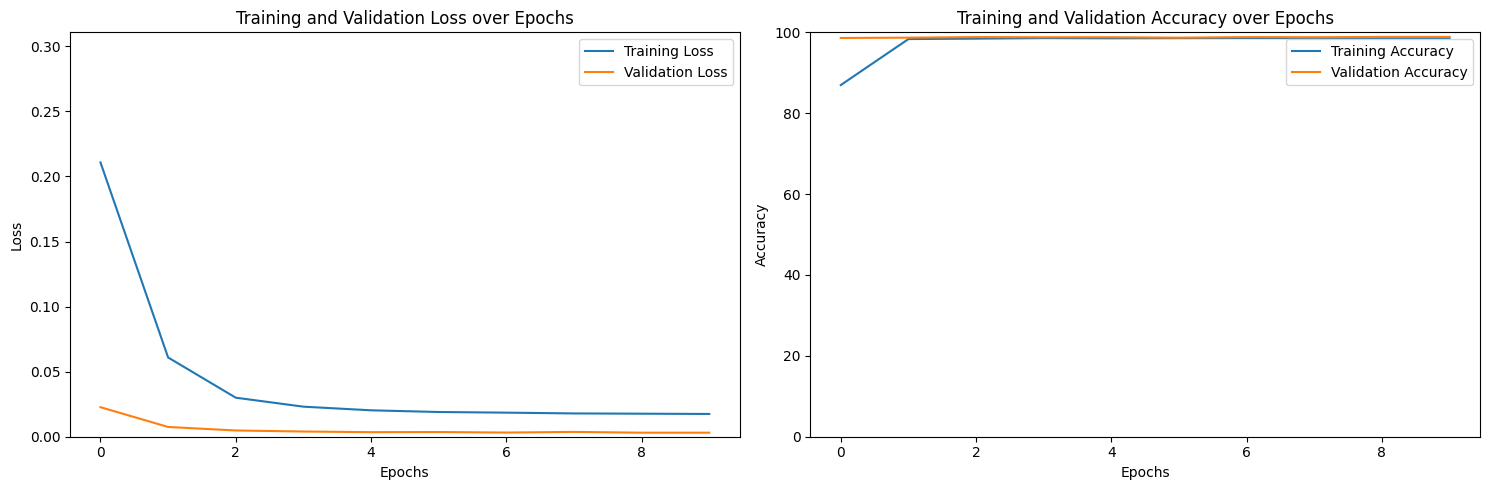

In [60]:
def plot_metrics(total_loss_train_plot, total_loss_validation_plot, total_acc_train_plot, total_acc_validation_plot):
    """
    Plots the training and validation loss and accuracy over epochs.

    Args:
        total_loss_train_plot (list): Training loss values.
        total_loss_validation_plot (list): Validation loss values.
        total_acc_train_plot (list): Training accuracy values.
        total_acc_validation_plot (list): Validation accuracy values.
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plot Loss
    axs[0].plot(total_loss_train_plot, label='Training Loss')
    axs[0].plot(total_loss_validation_plot, label='Validation Loss')
    axs[0].set_title('Training and Validation Loss over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_ylim([0, max(max(total_loss_train_plot), max(total_loss_validation_plot)) + 0.1])  # Dynamic ylim for loss
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(total_acc_train_plot, label='Training Accuracy')
    axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
    axs[1].set_title('Training and Validation Accuracy over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_ylim([0, 100])
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_metrics(total_loss_train_plot, total_loss_validation_plot, total_acc_train_plot, total_acc_validation_plot)

# 15. Inference

In [62]:
def infer_rice_class(model, original_df, device, scaler):
    """
    Infers the rice class based on user input and the trained model.

    Args:
        model (nn.Module): The trained rice classification model.
        original_df (pd.DataFrame): The original DataFrame used for training.
        device (str): The device to run the inference on ('cuda' or 'cpu').
        scaler (MinMaxScaler): The scaler object fitted on the original data.

    Returns:
        int: The predicted rice class (0 or 1).
    """
    # Get user input for rice features.

    area = float(input("Area: "))
    MajorAxisLength = float(input("Major Axis Length: "))
    MinorAxisLength = float(input("Minor Axis Length: "))
    Eccentricity = float(input("Eccentricity: "))
    ConvexArea = float(input("Convex Area: "))
    EquivDiameter = float(input("EquivDiameter: "))
    Extent = float(input("Extent: "))
    Perimeter = float(input("Perimeter: "))
    Roundness = float(input("Roundness: "))
    AspectRation = float(input("AspectRation: "))

    # Create a list of input features.
    my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea,
                 EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

    # Create a DataFrame for the input data and normalize it using the scaler.
    input_df = pd.DataFrame([my_inputs], columns=original_df.columns[:-1])  # Exclude 'Class' column
    normalized_inputs = scaler.transform(input_df)

    # Make prediction using the model.
    model_inputs = torch.Tensor(normalized_inputs[0]).to(device)  # Get the first (and only) row
    prediction = model(model_inputs)

    # Print the prediction and the predicted class.
    print("=" * 20)
    print("Prediction (probability):", prediction.item())
    print("Predicted Class:", round(prediction.item()))

    return round(prediction.item())

# ... (Assuming you have already fitted the scaler earlier)

# Example usage:
predicted_class = infer_rice_class(model, original_df, device, scaler)

'''
  Area: 6431.279
  Major Axis Length: 145.21338
  Minor Axis Length: 56.902
  Eccentricity: 0.919981821
  Convex Area: 6518.93759999
  EquivDiameter: 90.483541
  Extent: 0.8506668
  Perimeter: 329.972
  Roundness: 0.742255516
  AspectRation: 2.551696
'''

Area: 6431
Major Axis Length: 145
Minor Axis Length: 56
Eccentricity: 0.9
Convex Area: 6518
EquivDiameter: 90
Extent: 0.85
Perimeter: 329
Roundness: 0.74
AspectRation: 2.55
Prediction (probability): 0.8297666311264038
Predicted Class: 1


'\n  Area: 6431.279\n  Major Axis Length: 145.21338\n  Minor Axis Length: 56.902\n  Eccentricity: 0.919981821\n  Convex Area: 6518.93759999\n  EquivDiameter: 90.483541\n  Extent: 0.8506668\n  Perimeter: 329.972\n  Roundness: 0.742255516\n  AspectRation: 2.551696\n'